"""

New dataset is small and similar to original dataset: 
    train a linear classifier on the CNN codes.
New dataset is large and similar to the original dataset: 
    fine-tune through the full network.
New dataset is small but very different from the original dataset: 
    train the SVM classifier from activations somewhere earlier in the network.
New dataset is large and very different from the original dataset.
    we can afford to train a ConvNet from scratch.
    initialize with weights from a pretrained model, fine-tune through the entire network.

"""

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  # interactive mode


"""

We will use torchvision and torch.utils.data packages 
for loading the data.

The problem is to train a model to classify ants and bees.
We have about 120 training images each for ants and bees. 
There are 75 validation images for each class.

This dataset is a very small subset of imagenet.

"""

## Load Data

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),   # for better generalization
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Visualize a few images

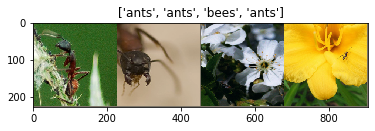

In [27]:
def imshow(inp, title=None):
    # Imshow for Tensor
    inp = inp.numpy().transpose((1, 2,  0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [26]:
# a general function to train a model
# scheduling the learning rate
# saving the best model

# parameter scheduler is an LR scheduler object 
# from torch.optim.lr_scheduler

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch, num_epochs - 1))  #print the results
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()    # set model to training mode
            else:
                model.eval()    # set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # forward
                # track hitory if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
    time_elapsed = time.time() - since
    print('Trianing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [29]:
# Generic function to display predictions for a few images

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

In [21]:
# load a pretrained model and reset the fully connected layer

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)    # nn.Linear(input, weight, bia=None)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0 / 24
----------
train Loss: 0.7540 Acc: 0.6598
val Loss: 0.2284 Acc: 0.9150

Epoch 1 / 24
----------
train Loss: 0.6113 Acc: 0.7541
val Loss: 0.4852 Acc: 0.8105

Epoch 2 / 24
----------
train Loss: 0.4913 Acc: 0.7992
val Loss: 0.3982 Acc: 0.8431

Epoch 3 / 24
----------
train Loss: 0.5815 Acc: 0.7828
val Loss: 0.3503 Acc: 0.8627

Epoch 4 / 24
----------
train Loss: 0.5066 Acc: 0.8156
val Loss: 0.5193 Acc: 0.8039

Epoch 5 / 24
----------
train Loss: 0.7432 Acc: 0.7541
val Loss: 0.8006 Acc: 0.8039

Epoch 6 / 24
----------
train Loss: 0.4465 Acc: 0.8320
val Loss: 0.3596 Acc: 0.8758

Epoch 7 / 24
----------
train Loss: 0.3969 Acc: 0.8443
val Loss: 0.3435 Acc: 0.8889

Epoch 8 / 24
----------
train Loss: 0.2628 Acc: 0.8811
val Loss: 0.3242 Acc: 0.8824

Epoch 9 / 24
----------
train Loss: 0.3264 Acc: 0.8607
val Loss: 0.2662 Acc: 0.9281

Epoch 10 / 24
----------
train Loss: 0.3639 Acc: 0.8484
val Loss: 0.3539 Acc: 0.8693

Epoch 11 / 24
----------
train Loss: 0.4020 Acc: 0.8402
val Loss

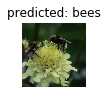

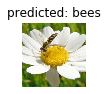

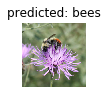

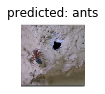

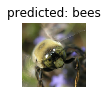

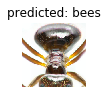

In [32]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [35]:
# We need to freeze all the network except the final layer.
# set requires_grad == false to freeze the parameters 

model_conv = torchvision.models.resnet18(pretrained=True)
for params in model_conv.parameters():
    params.requires_grad = False
    
# Params of newly constructed modules have gradients attached by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# only params of final fc layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

#Decay LR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [36]:
model_conv = train_model(model_conv, criterion, optimizer_conv, 
                        exp_lr_scheduler, num_epochs=25)

Epoch 0 / 24
----------
train Loss: 0.7230 Acc: 0.5615
val Loss: 0.2318 Acc: 0.9216

Epoch 1 / 24
----------
train Loss: 0.5717 Acc: 0.7418
val Loss: 0.3771 Acc: 0.8301

Epoch 2 / 24
----------
train Loss: 0.4496 Acc: 0.8074
val Loss: 0.1837 Acc: 0.9608

Epoch 3 / 24
----------
train Loss: 0.5639 Acc: 0.7664
val Loss: 0.1936 Acc: 0.9477

Epoch 4 / 24
----------
train Loss: 0.3836 Acc: 0.8156
val Loss: 0.1880 Acc: 0.9477

Epoch 5 / 24
----------
train Loss: 0.5071 Acc: 0.8156
val Loss: 0.2316 Acc: 0.9477

Epoch 6 / 24
----------
train Loss: 0.3240 Acc: 0.8484
val Loss: 0.2040 Acc: 0.9477

Epoch 7 / 24
----------
train Loss: 0.3550 Acc: 0.8484
val Loss: 0.1741 Acc: 0.9542

Epoch 8 / 24
----------
train Loss: 0.3413 Acc: 0.8320
val Loss: 0.1761 Acc: 0.9542

Epoch 9 / 24
----------
train Loss: 0.3674 Acc: 0.8197
val Loss: 0.1891 Acc: 0.9542

Epoch 10 / 24
----------
train Loss: 0.3443 Acc: 0.8443
val Loss: 0.1795 Acc: 0.9542

Epoch 11 / 24
----------
train Loss: 0.3256 Acc: 0.8484
val Loss

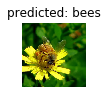

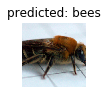

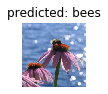

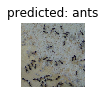

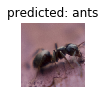

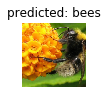

In [37]:
visualize_model(model_conv)

plt.ioff()
plt.show()